# Dependências

In [1]:
import logging as log
import re
import math as ma
import pprint as pp
import numpy as np
import pandas as pd
import transformer as tr
import parzen as pa
from sklearn import naive_bayes as nb
from sklearn import pipeline as pi
from sklearn import model_selection as ms
from sklearn import ensemble as en
import scipy.stats as st
import Orange as og
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Configurações de log

In [2]:
logger = log.getLogger('logger')
logger.setLevel(log.DEBUG)
# sklearn só gera log quando nível é DEBUG ou INFO
verbose = max((log.WARNING - logger.getEffectiveLevel()), 0)

# 2) Conhecendo os dados de "Image Segmentation"

## Leiaute
Shape view: as primeiras 9 variáveis<br>
RGB view: as 10 últimas variáveis

Observando a amostra abaixo, foi verificado que o rótulo se encontra na coluna mais à esquerda e as demais colunas são as variáveis. Conforme enunciado da questão, trata-se de um problema de classificação multiclasse, cujos rótulos são BRICKFACE, SKY, FOLIAGE, CEMENT, WINDOW, PATH, GRASS.

In [3]:
data = pd.read_csv('segmentation.test', skiprows=[0,1,2,4])
data = data.reset_index() # move rótulo do índice para uma coluna
data = data.rename(index=str, columns={'index': 'LABEL'}) # renomeia coluna do rótulo
data.head(3)

,LABEL,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,GRASS,110.0,189.0,9,0.0,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
1,GRASS,86.0,187.0,9,0.0,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
2,GRASS,225.0,244.0,9,0.0,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902


Antes de passar os dados para os classificadores, é preciso confirmar que os tipos das variáveis são todos numéricos. A tabela abaixo confirma isso, pois os tipos presentes se limitam a float64 e int64. Além disso, a amostra de dados acima deixa claro que não há variáveis com dados categóricos, pois são todos ordinais. Nesse caso, as variáveis já estão em formatos compatíveis com os classificadores que serão usados mais à frente, sem a necessidade de pré-processamento.

In [4]:
data.dtypes

LABEL                    object
REGION-CENTROID-COL     float64
REGION-CENTROID-ROW     float64
REGION-PIXEL-COUNT        int64
SHORT-LINE-DENSITY-5    float64
SHORT-LINE-DENSITY-2    float64
VEDGE-MEAN              float64
VEDGE-SD                float64
HEDGE-MEAN              float64
HEDGE-SD                float64
INTENSITY-MEAN          float64
RAWRED-MEAN             float64
RAWBLUE-MEAN            float64
RAWGREEN-MEAN           float64
EXRED-MEAN              float64
EXBLUE-MEAN             float64
EXGREEN-MEAN            float64
VALUE-MEAN              float64
SATURATION-MEAN         float64
HUE-MEAN                float64
dtype: object

## Estatísticas

A tabela abaixo mostra que as variáves não estão na mesma escala e nem possuem a mesma média, mas isso não será um problema para os classificadores a serem usados mais à frente: bayesiano gaussiano e bayesiano baseado em janela de Parzen com função de kernel.

In [5]:
data.describe()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
count,2100.000000,2100.000000,2100.0,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2.100000e+03,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,124.940476,123.483333,9.0,0.014921,0.004550,1.890820,5.708299,2.406772,7.904224e+00,37.047654,32.806667,44.205556,34.130741,-12.722963,21.473704,-8.750741,45.162381,0.427259,-1.365147
std,72.858637,57.431428,0.0,0.041024,0.023573,2.649453,44.989359,3.469954,5.347107e+01,38.135291,34.994538,43.510119,36.303768,11.588214,19.654107,11.606996,42.900582,0.228458,1.544278
min,1.000000,11.000000,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.589457e-08,0.000000,0.000000,0.000000,0.000000,-49.666668,-12.444445,-33.888890,0.000000,0.000000,-3.044175
25%,62.000000,81.000000,9.0,0.000000,0.000000,0.722222,0.349603,0.833332,4.216377e-01,7.472222,7.000000,9.666667,6.222222,-18.583333,4.305556,-17.000000,11.777778,0.284934,-2.188539
50%,121.000000,122.000000,9.0,0.000000,0.000000,1.277776,0.833333,1.444444,9.897442e-01,21.666666,19.666668,27.777779,20.444445,-10.888889,19.666666,-11.000000,28.666666,0.375064,-2.052625
75%,188.250000,171.250000,9.0,0.000000,0.000000,2.222221,1.807406,2.555556,2.251852e+00,53.277778,47.333332,65.000000,46.388888,-4.222222,36.111110,-3.222222,65.000000,0.540228,-1.565745
max,254.000000,251.000000,9.0,0.333333,0.222222,29.222221,991.718400,44.722225,1.386329e+03,143.444440,137.111110,150.888890,142.555560,9.888889,82.000000,24.666666,150.888890,1.000000,2.912480


## Seleção de variáveis

A partir da tabela acima, também é possível verificar que a variável REGION-PIXEL-COUNT possui um desvio padrão igual a zero. Isso a torna irrelevante para os classificadores e pode até criar complicações na validação cruzada para definição da janela do classificador bayesiano baseado em janela de Parzen. Por isso, ela será excluída do conjunto de dados.

In [6]:
data = data.drop(columns=['REGION-PIXEL-COUNT'])

## a)  Execução do experimento.

Esta seção tem o objetido de repetir a validação cruzada estratificada "30 times ten fold" para cada classificador e para cada visão das variáveis. Para isso, vários passos de preparação e buscas em grid serão realizados para ajuste de parâmetros e a execução propriamente dita dos classificadores.<br>
Todos os passos serão descritos a seguir:

1) Definir uma semente para estado aleatório do experimento.

In [7]:
# dez primeiros dígitos de pi
seed = round(ma.pi * 10**9)
seed

3141592654

2) Separar o rótulo das variáveis.

In [8]:
# variáveis
X = data[data.columns[1:]]
# rótulo
y = data['LABEL']

3) Busca em grid para encontrar o melhor tamanho de janela para o conjunto de dados em questão. O tamanho de janela escolhido será utilizado na configuração do classificador bayesiano baseado em janela de Parzen.

In [9]:
# TODO mover para dentro do classificador de janela de Parzen
# o grid de parâmetros abaixo define os possíveis valores da janela
param_grid = {'bandwidth': [1, 2.5, 5, 7.5, 10]}
grid_search = ms.GridSearchCV(pa.ParzenWindowB(), param_grid=param_grid, cv=ms.RepeatedStratifiedKFold(n_splits=10,n_repeats=1,random_state=seed),return_train_score=False)
grid_search.fit(X, y)
bw = grid_search.best_params_['bandwidth']
bw

5

3) Busca em grid para repetir a validação cruzada extratificada para cada combinação de visão e classificador.<br>
Uma estrutura de pipeline com dois passos é criada para dar suporte à montagem das combinações. O primeiro passo do pipeline consiste na transformação que define a visão das variáveis e o segundo no classificador a ser avaliado.<br>
Nos parâmetros da busca em grid, são listadas todas as opções de visões das variáveis e classificadores a serem combinadas, seguindo a estrutura do pipeline. Conforme enunciado da questão, as visões das variáveis devem ser complete, shape e rgb e os classificadores devem ser bayesiano gaussiano e bayesiano baseado em janela de Parzen, fazendo uso da janela identificada anteriormente.<br>
Devido à diferença na estrutura do pipeline, o classificador combinado será avaliado em outra busca em grid, descrita mais à frente.

In [10]:
# o grid de parâmetros abaixo define as possíveis combinações de visões e classificadores do classificador combinado
param_grid = {'a_view': [tr.CompleteView(), tr.ShapeView(), tr.RgbView()],
              'b_clf': [nb.GaussianNB(), pa.ParzenWindowB(bandwidth=bw)]}
# todas as combinações de passos
all_steps = list(map(lambda params: list(params.items()), ms.ParameterGrid(param_grid)))
pipelines = list(map(lambda steps: ('clf'+str(all_steps.index(steps)), pi.Pipeline(steps)), all_steps))
combined = en.VotingClassifier(estimators=pipelines, voting='soft')
# os passos abaixo definem apenas a estrutura do pipeline
steps = [('a_view', tr.CompleteView()),
         ('b_clf', nb.GaussianNB())]
pipe = pi.Pipeline(steps)
# dicionários dos nomes das visões e dos classificadores
views = {tr.CompleteView(): 'comp',
        tr.ShapeView(): 'shape',
        tr.RgbView(): 'rgb'}
clfs = {nb.GaussianNB(): 'gnb',
        pa.ParzenWindowB(bandwidth=bw): 'pwb'}
# o grid de parâmetros abaixo define todas as opções de visões e classificadores simples 
# e uma opção com o classificador combinado
param_grid = [{'a_view': list(views.keys()),
               'b_clf': list(clfs.keys())},
              {'b_clf': [combined]}
             ]
# a busca em grid repete o experimento para cada combinação de opções
# TODO deixar com 10 splits e 30 repetições
grid_search = ms.GridSearchCV(pipe, param_grid=param_grid, cv=ms.RepeatedStratifiedKFold(n_splits=10,n_repeats=30,random_state=seed),verbose=verbose,return_train_score=False)
#grid_search = ms.GridSearchCV(pipe, param_grid=param_grid, cv=ms.RepeatedStratifiedKFold(n_splits=10,n_repeats=2,random_state=seed),verbose=verbose,return_train_score=False)
grid_search.fit(X, y);

Fitting 300 folds for each of 7 candidates, totalling 2100 fits
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7666666666666667, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_vi

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  1

[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7666666666666667, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ..

[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7619047619047619, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8095238095238095, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(

[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7571428571428571, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8333333333333334, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7619047619047619, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(

[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]

[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8095238095238095, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ..

[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9428571428571428, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9666666666666667, total=   1.2s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9476190476190476, total=   1.2s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9619047619047619, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9619047619047619, total=   1.1s
[CV] a_view=CompleteView(),

[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9619047619047619, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9476190476190476, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9428571428571428, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9666666666666667, total=   1.2s
[CV] a_view=CompleteView(),

[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9523809523809523, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9428571428571428, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9476190476190476, total=   1.1s
[CV] a_view=CompleteView(),

[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9523809523809523, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9666666666666667, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9333333333333333, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9476190476190476, total=   1.1s
[CV] a_view=CompleteView(),

[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9666666666666667, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9666666666666667, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9619047619047619, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(),

[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9238095238095239, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9714285714285714, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9714285714285714, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9333333333333333, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(),

[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9333333333333333, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9380952380952381, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9619047619047619, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9571428571428572, total=   1.1s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5) .........
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5), score=0.9428571428571428, total=   1.1s
[CV] a_view=CompleteView(),

[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4523809523809524, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.45714285714285713, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.49047619047619045, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV

[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.48095238095238096, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.41904761904761906, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.49047619047619045, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.46190476190476193, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.49523809523809526, total=   0.0s
[C

[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.48095238095238096, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4238095238095238, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4523809523809524, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.49047619047619045, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.48095238095238096, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ....

[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5142857142857142, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4523809523809524, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5047619047619047, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, tot

[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.49047619047619045, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5047619047619047, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5047619047619047, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.41904761904761906, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.48095238095238096, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]

[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5619047619047619, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5476190476190477, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5857142857142857, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5571428571428572, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5571428571428572, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5428571428571428, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(

[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5476190476190477, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.6142857142857143, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5904761904761905, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.580952380952381, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5428571428571428, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.580952380952381, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(ba

[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.6047619047619047, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5571428571428572, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5857142857142857, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5476190476190477, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5666666666666667, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5428571428571428, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(

[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5095238095238095, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5476190476190477, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5476190476190477, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.6095238095238096, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5666666666666667, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5047619047619047, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(

[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5428571428571428, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.6095238095238096, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5333333333333333, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5142857142857142, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.6, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.580952380952381, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ...

[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.580952380952381, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.6095238095238096, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5714285714285714, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5571428571428572, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5666666666666667, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5) ............
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5), score=0.5571428571428572, total=   0.5s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(b

[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7571428571428571, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8333333333333334, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7714285714285715, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbVie

[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8476190476190476, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.819047619047619, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.780952380952381, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7714285714285715, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  

[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8238095238095238, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7714285714285715, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8428571428571429, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]

[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8238095238095238, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8380952380952381, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7714285714285715, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]

[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7714285714285715, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7619047619047619, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8333333333333334, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV] a_view=RgbView(), b_clf=Gauss

[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8380952380952381, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8428571428571429, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8285714285714286, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8571428571428571, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8142857142857143, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.819047619047619, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..

[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8047619047619048, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8952380952380953, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.7952380952380952, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8428571428571429, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8428571428571429, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8142857142857143, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) .

[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8333333333333334, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8571428571428571, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8571428571428571, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8238095238095238, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8380952380952381, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[

[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8761904761904762, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8809523809523809, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8285714285714286, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.861904761904762, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.819047619047619, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8238095238095238, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ...

[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8476190476190476, total=   0.7s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8238095238095238, total=   0.7s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8238095238095238, total=   0.7s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.819047619047619, total=   0.7s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8047619047619048, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8523809523809524, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..

[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8476190476190476, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8380952380952381, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8380952380952381, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8571428571428571, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.819047619047619, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..............
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5), score=0.8666666666666667, total=   0.6s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5) ..

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9238095238095239, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.919047619047619, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tran

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9333333333333333, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9380952380952381, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.919047619047619, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tran

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9095238095238095, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9333333333333333, total=   2.6s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9142857142857143, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.8857142857142857, total=   2.3s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9333333333333333, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9142857142857143, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9285714285714286, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9095238095238095, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9428571428571428, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9285714285714286, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9476190476190476, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9333333333333333, total=   2.4s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9047619047619048, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9095238095238095, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9380952380952381, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9523809523809523, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9142857142857143, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.919047619047619, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tran

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9285714285714286, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.8952380952380953, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9142857142857143, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9476190476190476, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.8952380952380953, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9142857142857143, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9380952380952381, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9333333333333333, total=   2.1s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9142857142857143, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.919047619047619, total=   2.3s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tran

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9095238095238095, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9571428571428572, total=   2.2s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_tra

[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5))])), ('clf2', Pipeline(memory=None,
     steps=[('a_view', ShapeView()..., Pipeline(memory=None,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9095238095238095, total=   2.2s


[Parallel(n_jobs=1)]: Done 2100 out of 2100 | elapsed: 22.2min finished


In [11]:
logger.debug(pp.pformat(grid_search.cv_results_))

1) Unir dicionários de nomes para realizar formatação dos resultados.

In [12]:
names = dict(views)
names.update(clfs)
names[combined] = 'combined'

## b) Avaliação dos resultados.

Esta seção tem o objetivo de extrair os dados do experimento, obter uma estimativa pontual e um intervalo de confiança para a taxa de acerto de cada classificador.

1) Extração dos dados

In [13]:
# TODO mover do notebook para uma classe
def param_to_col_name(params_dict):
    name = map(lambda x: names[x], params_dict.values())
    return '_'.join(name)
result = pd.DataFrame(data=grid_search.cv_results_)
score_columns = filter(lambda key: re.match(r'split\d+_test_score', key), grid_search.cv_results_.keys())
#score_columns = map(lambda col_name: int(re.search(r'split(\d+)_test_score', col_name).group(1)), score_columns)
score_columns = list(score_columns)
result = result[['params'] + score_columns]
result['params'] = result['params'].apply(param_to_col_name)
result = result.T
result.columns = result.iloc[0]
result = result.drop(['params'])
result.index = map(lambda idx: int(re.search(r'split(\d+)_test_score', idx).group(1)), score_columns)
result.columns = result.columns.rename('fold')
result = result.infer_objects()
result = result.groupby(result.index // 10).mean()
result

fold,comp_gnb,comp_pwb,shape_gnb,shape_pwb,rgb_gnb,rgb_pwb,combined
0,0.798095,0.953810,0.478571,0.570952,0.794286,0.830952,0.925714
1,0.795714,0.953810,0.471905,0.576190,0.795238,0.827143,0.924762
2,0.796667,0.957619,0.479048,0.570476,0.790476,0.829048,0.924762
3,0.799048,0.957143,0.473333,0.566667,0.794762,0.830000,0.930952
4,0.794762,0.954286,0.479048,0.573810,0.800000,0.829524,0.929048
5,0.799048,0.956190,0.477143,0.574286,0.795238,0.832857,0.927143
6,0.795714,0.951905,0.477143,0.571429,0.792381,0.830000,0.923333
7,0.796190,0.954762,0.474286,0.569524,0.795238,0.830952,0.923333
8,0.796667,0.954762,0.473810,0.569048,0.798095,0.827619,0.925238
9,0.799048,0.954762,0.475714,0.567143,0.796667,0.831429,0.925238


) Estimativa pontual e intervalo de confiança da taxa de acerto. "score_mean" exibe a média da taxa de acerto e "confidence_interval" mostra o intervalo no qual há 95% confiança de que o "score_mean" está presente, dado que "score_mean" é uma variável aleatória de distribuição normal, conforme o Teorema do Limite Central.

In [14]:
estimate = result.apply(st.bayes_mvs, alpha=0.95)
estimate = pd.DataFrame.from_records(estimate.T.tolist(), index=estimate.index.rename('clf'), columns=['score_mean', 'variance', 'std_dev'])
estimate = pd.DataFrame.from_records(estimate['score_mean'].tolist(), index=estimate.index, columns=['score_mean', 'confidence_interval'])
estimate

,score_mean,confidence_interval
clf,,
comp_gnb,0.796857,"(0.796384152991, 0.797330132723)"
comp_pwb,0.954508,"(0.953923336469, 0.955092536547)"
shape_gnb,0.476127,"(0.475321249765, 0.476932718489)"
shape_pwb,0.570444,"(0.569427875629, 0.571461013259)"
rgb_gnb,0.795317,"(0.794500505578, 0.796134415057)"
rgb_pwb,0.830095,"(0.82941951853, 0.83077095766)"
combined,0.925651,"(0.924905510943, 0.926396076358)"


## c) Comparação dos classificadores.

) Testar hipótese nula de que as taxas de acerto possuem a mesma distribuição. Em outras palavras, que os classificadores possuem a mesma performance.<br>
O teste utilizado é o teste de Friedman.

In [15]:
measurements = np.asarray(result.T)
test_stat, p_value = st.friedmanchisquare(*measurements)
print(test_stat)
p_value

177.911799762


9.4194712315349006e-36

 ) Rejeitar a hipótese nula, já que p_value < 0.05.

) Comparar pares de classificadores para identificar quais diferenças de taxa de acerto estão acima do valor crítico. Em outras palavras, quais pares de classificadores são signaficamente diferente.<br>
O teste utilizado é o Teste de Nemenyi.

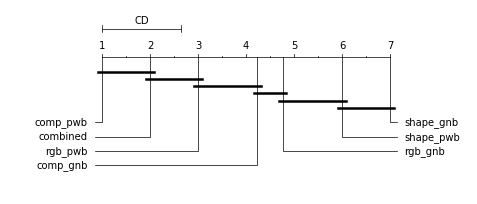

In [16]:
avg_rank = result.rank(axis=1, ascending=False)
avg_rank = avg_rank.mean()
cd = og.evaluation.compute_CD(avranks=avg_rank, n=len(result), alpha='0.05', test='nemenyi')
og.evaluation.graph_ranks(avranks=avg_rank, names=result.columns, cd=cd)
plt.show()